Transfer Learning  

Convolutional NN  
ELU (Exponential Linear Unit) Hidden Layer Activation Function  
SoftMax Output Layer Activation Function  
Categorical Cross Entropy Loss Function

Batch normalization between layers  
Play with learning rate (0.001, 0.01, 0.1) and batch size (small or big? more can help performance but costs runtime)

In [1]:
# %tensorflow_version 2.x
# from tensorflow.keras import datasets, layers, models

from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow import keras

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn import metrics
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sn
import pandas as pd
from google.colab import drive

Using TensorFlow backend.


### Make the Dataset

In [0]:
batch_size = 64
img_height = 175
img_width = 175
epochs = 15

In [3]:
drive.mount('/content/drive')
data_dir = '/content/drive/My Drive/FlowersMetis/flowers/train'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',
    seed=42,
    subset='training') # set as training data

validation_generator = datagen.flow_from_directory(
    data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',
    seed=42,
    subset='validation') # set as validation data

test_gen = ImageDataGenerator(rescale=1./255)
test_dir = '/content/drive/My Drive/FlowersMetis/flowers/test'
test_generator = test_gen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = 37
    )

Found 5087 images belonging to 3 classes.
Found 1271 images belonging to 3 classes.
Found 752 images belonging to 3 classes.


In [0]:
# this section could use some better programming
num_of_train_samples = 5087
num_of_val_samples = 1271
num_of_test_samples = 752
class_count = 3
class_names = ['irises', 'roses', 'sempervivum']

In [0]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        label_location = np.argmax(label_batch[n])
        plt.title(class_names[label_location]) # the train_generator.class_indices labels are stored alphabetically, so using class_names from earlier is also viable as it is also alphabetical
        plt.axis('off')

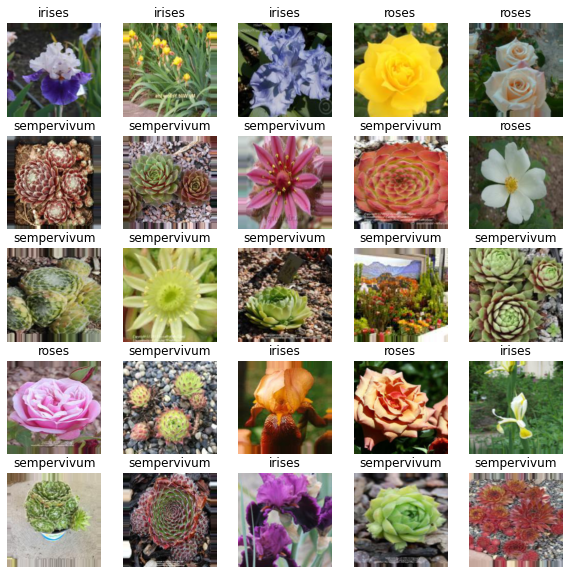

In [7]:
image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch)

### Make a Model

In [9]:
# copy VGG-16 exactly for a test go

input_shape = (175, 175, 3)

model = Sequential([
Conv2D(64, (3, 3), input_shape=input_shape, padding='same', activation='relu'),
Conv2D(64, (3, 3), activation='relu', padding='same'),
MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
Conv2D(128, (3, 3), activation='relu', padding='same'),
Conv2D(128, (3, 3), activation='relu', padding='same',),
MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
Conv2D(256, (3, 3), activation='relu', padding='same',),
Conv2D(256, (3, 3), activation='relu', padding='same',),
Conv2D(256, (3, 3), activation='relu', padding='same',),
MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
Conv2D(512, (3, 3), activation='relu', padding='same',),
Conv2D(512, (3, 3), activation='relu', padding='same',),
Conv2D(512, (3, 3), activation='relu', padding='same',),
MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
Conv2D(512, (3, 3), activation='relu', padding='same',),
Conv2D(512, (3, 3), activation='relu', padding='same',),
Conv2D(512, (3, 3), activation='relu', padding='same',),
MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
Flatten(),
Dense(4096, activation='relu'),
Dense(4096, activation='relu'),
Dense(class_count, activation='softmax')
])

In [14]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(175, 175, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))

#bigger?!!?
# model.add(Conv2D(256, (3, 3), activation='relu')) #remove?
# model.add(Conv2D(256, (3, 3), activation='relu')) #remove?
# model.add(Conv2D(256, (3, 3), activation='relu')) #remove?
# model.add(MaxPool2D((2, 2)))                       #remove?

# model.add(Conv2D(128, (3, 3), activation='relu')) #remove?
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(MaxPool2D((2, 2)))

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))

model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(class_count, activation='softmax'))

In [0]:
optimizer = Adam()
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy']) #changed from sparse_cat_crossent after switching the generator class_mode to categorical
model.summary()

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, factor=0.1, min_lr=0.00001) #changed factor from 0.5 to 0.1
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, factor=0.5, min_lr=0.0001)
early_stopping = EarlyStopping(patience=8, verbose=1, restore_best_weights=True)

History = model.fit(train_generator,
    validation_data = validation_generator, 
    epochs = epochs,
    callbacks=[learning_rate_reduction, early_stopping]
    )

Epoch 1/15
80/80 [==============================] - 68s 853ms/step - loss: 0.7839 - acc: 0.6604 - val_loss: 1.1591 - val_acc: 0.5822
Epoch 2/15
80/80 [==============================] - 54s 678ms/step - loss: 0.6284 - acc: 0.7372 - val_loss: 0.8654 - val_acc: 0.7026
Epoch 3/15
80/80 [==============================] - 54s 677ms/step - loss: 0.5647 - acc: 0.7593 - val_loss: 0.5864 - val_acc: 0.7828
Epoch 4/15
80/80 [==============================] - 54s 678ms/step - loss: 0.5373 - acc: 0.7823 - val_loss: 0.7499 - val_acc: 0.7553
Epoch 5/15
80/80 [==============================] - 54s 675ms/step - loss: 0.5148 - acc: 0.7860 - val_loss: 0.5846 - val_acc: 0.7750
Epoch 6/15
80/80 [==============================] - 54s 673ms/step - loss: 0.4808 - acc: 0.7980 - val_loss: 0.5342 - val_acc: 0.7695
Epoch 7/15
80/80 [==============================] - 54s 674ms/step - loss: 0.4213 - acc: 0.8271 - val_loss: 0.4203 - val_acc: 0.8403
Epoch 8/15
80/80 [==============================] - 54s 676ms/step - 

### Save and Predict

In [96]:
model.save('/content/drive/My Drive/FlowersMetis')
# tf.keras.models.save_model(model, '/content/drive/My Drive/FlowersMetis')

OSError: ignored

In [0]:
y_pred = model.predict(test_generator)

## Prep for Charting

In [0]:
# convert predictions to binary

y_preds = []
for row in y_pred:
  temp_list = [0, 0, 0]
  max_idx = np.argmax(row)
  temp_list[max_idx] = 1
  y_preds.append(temp_list)


In [0]:
y_val = []
y_img = []
num_batches = int((num_of_test_samples/batch_size)+1)

for i in range(num_batches): # the necessary num of batches to call to get all values
    batch = next(test_generator)
    batch_label = batch[1] # get the test labels
    batch_img = batch[0] # get the test image
    for j in range(len(batch_label)): # go through each row of the batch
        row = list(batch_label[j])
        temp_list = []
        for val in row:
            temp_list.append(int(val))
        y_val.append(temp_list)
        y_img.append(batch_img[j])

In [0]:
y_val = np.array(y_val)
y_preds = np.array(y_preds)

In [0]:
# print(test_generator.classes)

In [0]:
# get text for each 
y_pred_text = []
for row in y_preds:
    for class_idx, val in enumerate(row):
        if val == 1:
            y_pred_text.append(class_names[class_idx])
        
        
y_val_text = []
for row in y_val:
   for class_idx, val in enumerate(row):
        if val == 1:
            y_val_text.append(class_names[class_idx])

# Show Images with Prediction

In [0]:
def plot_image(i, y_pred, true_label, img):
    y_pred, true_label, img = y_pred[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(y_pred)
    true_label = np.argmax(true_label)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(y_pred),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, y_pred, true_label):
    y_pred = y_pred[i]
    plt.grid(False)
    plt.yticks([])
    thisplot = plt.bar(range(class_count), y_pred, color="#777777")
    plt.ylim([0, 1])    
    predicted_label = np.argmax(y_pred)
    true_label = np.argmax(true_label[i])
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

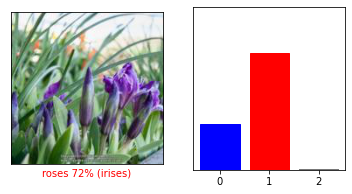

In [129]:
i = 9
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, y_pred, y_val, y_img)
plt.subplot(1,2,2)
plot_value_array(i, y_pred,  y_val)
plt.show()

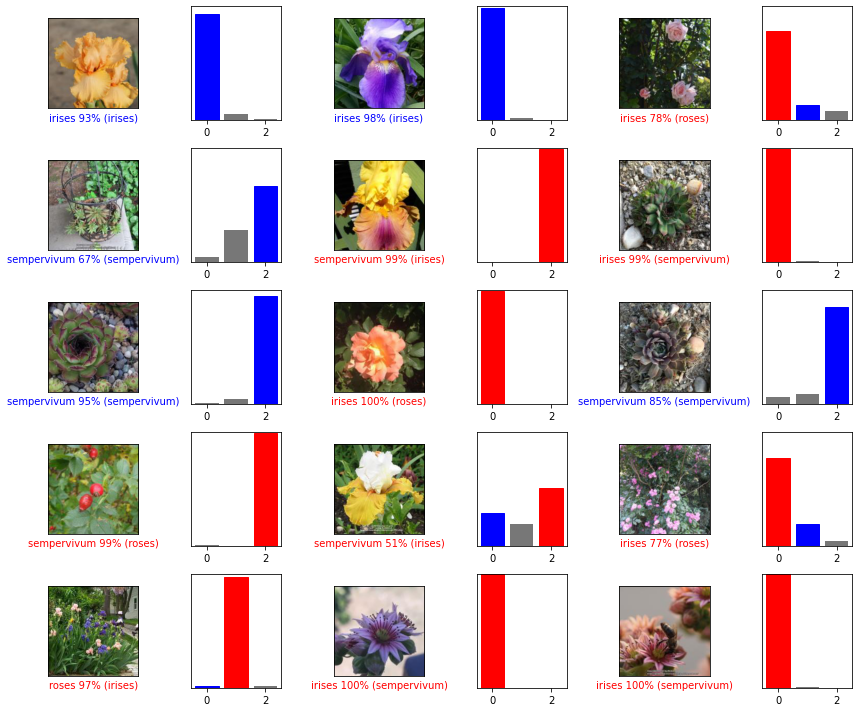

In [130]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
skip = 20
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i+skip, y_pred, y_val, y_img)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i+skip, y_pred,  y_val)
plt.tight_layout()
plt.show()

# Performance Metrics

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


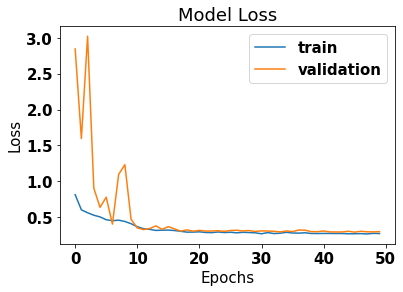

In [153]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

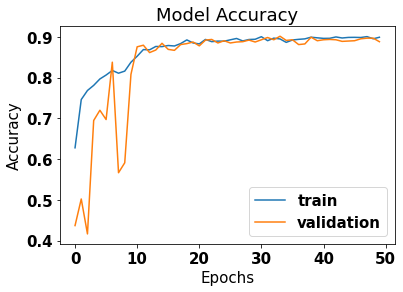

In [154]:
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

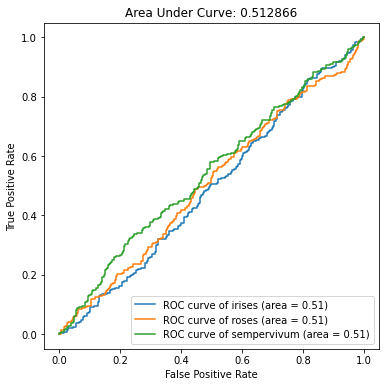

In [133]:
plt.figure(figsize=(6, 6))

for i in range(len(class_names)):
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_val[:,i], y_pred[:,i])
    auc = roc_auc_score(y_val, y_pred)
    plt.plot(false_positive_rate, true_positive_rate, label='ROC curve of '+class_names[i]+' (area = {1:0.2f})'
                               ''.format(i, auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Area Under Curve: %f' % auc)
plt.show()

In [134]:
# temp variable naming to save time for the moment -- code block copied from sklearn:
#  https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

y_prob = y_pred
y_test = y_val

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.512866 (macro),
0.512827 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.512866 (macro),
0.512827 (weighted by prevalence)


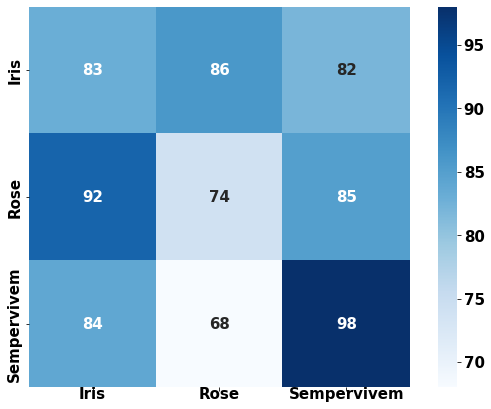

In [152]:
font = {'family' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

matrix = confusion_matrix(y_val_text, y_pred_text)
df_matrix = pd.DataFrame(matrix, index = class_names, columns = class_names)
plt.figure(figsize = (10,7))
plt.yticks(rotation=90, va="center", fontsize=15)
plt.xticks(va="center", fontsize=15)
sn.heatmap(matrix, cmap=plt.cm.Blues, annot=True, fmt='g', square=True
           , xticklabels=['Iris', 'Rose', 'Sempervivem'], yticklabels=['Iris', 'Rose', 'Sempervivem']
           )

### Return image that is similar in the final category

In [111]:
abs(y_pred)

array([[0.0448686 , 0.8911842 , 0.06394717],
       [0.14677326, 0.29906625, 0.5541605 ],
       [0.10345654, 0.5205423 , 0.3760011 ],
       ...,
       [0.40991145, 0.4378739 , 0.15221462],
       [0.01264633, 0.8876983 , 0.09965537],
       [0.09093428, 0.29717544, 0.61189026]], dtype=float32)